# Exercises

In [3]:
# connect to git to load all libraries and data

# get all files from the notebook here
!rm -rf single-cell-analysis
!git clone https://github.com/irenetiem/single-cell-analysis

import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("single-cell-analysis/01-tuning-curves/code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/z7mMiznEWOT0Iak')

Cloning into 'single-cell-analysis'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 147 (delta 53), reused 84 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 4.71 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (53/53), done.


## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader.


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes.

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?)


In [4]:
# A: change the binning

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

n_runs = 20
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate    # noise here!

spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

spike_positions = [np.interp(s, t, x) for s in spikes]

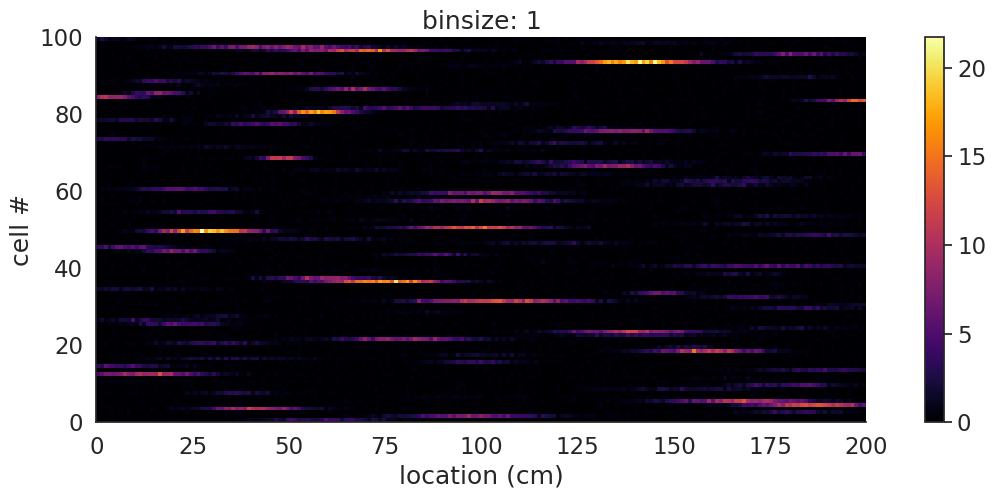

In [6]:
# here: set the binsize to 1 so it becomes more detailed

space_bins = np.arange(0., 200., 1)

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.title('binsize: 1')
plt.ylabel('cell #')
plt.colorbar()

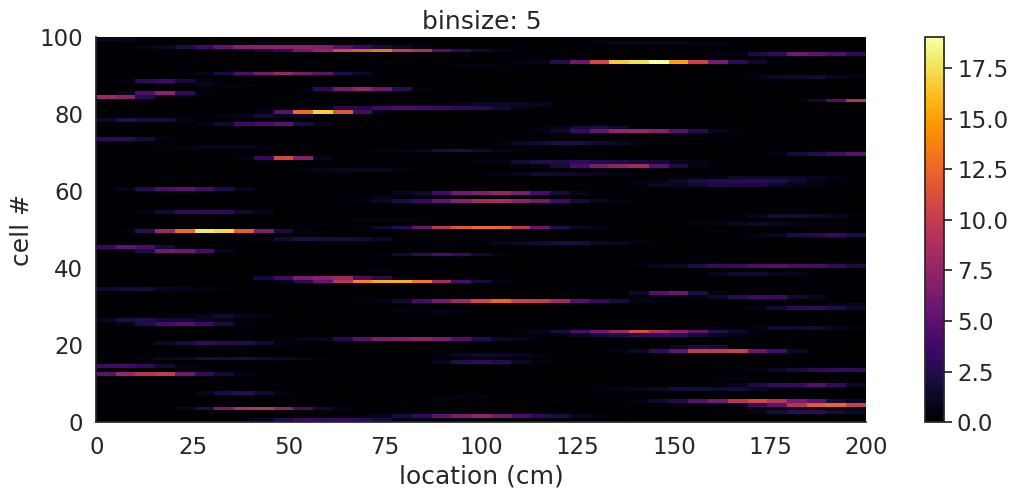

In [7]:
# now set the binsize to 15

space_bins = np.arange(0., 200., 5)

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.title('binsize: 5')
plt.ylabel('cell #')
plt.colorbar()

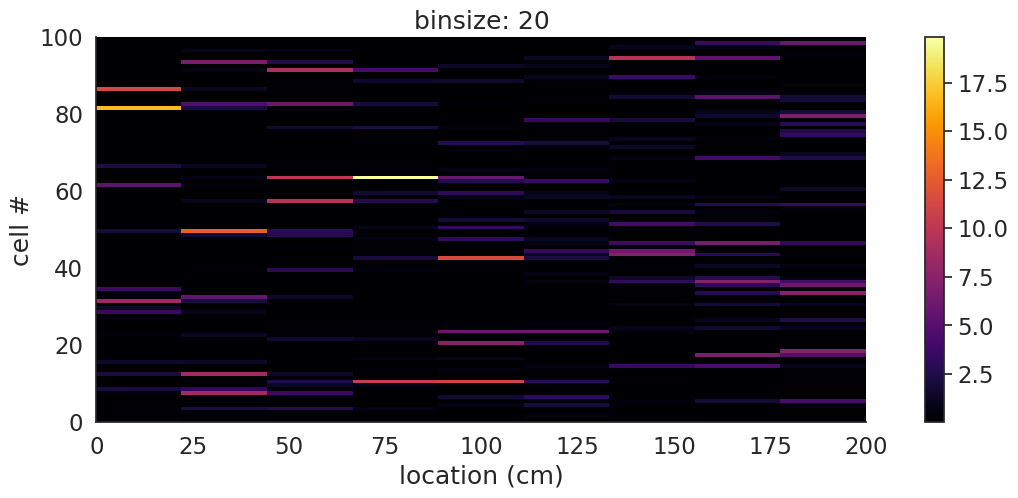

In [ ]:
# now one with really large binsize: 20

space_bins = np.arange(0., 200., 20)

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.title('binsize: 20')
plt.ylabel('cell #')
plt.colorbar()

**A** With a small binsize (1), there are more details visible about the locations and sensitivity of specific place cells, however, only 4 cells get into the 'yellow regime' and are nicely visible. Other cells almost fall to the background, as the input of several cells (not combined) is too little. On the other hand, with a large binsize, all cells are better visible, but lack detail.

**B** noise levels

In [23]:
# noise levels
# run with different noise levels

pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs)

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps


t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))

noise_firing_rate = 0.5 # the baseline noise firing rate    # noise here!

# spikes = []

# for i in tqdm(range(n_cells)):
#     inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
#     spikes_loc = np.random.poisson(inst_rate/sampling_rate)
#     sp = np.argwhere(spikes_loc)
#     t_sp = t_sampling[sp]
#     spikes.append(t_sp)

# spike_positions = [np.interp(s, t, x) for s in spikes]

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [72]:
def testing_noise_levels(noise_firing_rate):

  spikes = []

  for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

  spike_positions = [np.interp(s, t, x) for s in spikes]

  # plot it
  space_bins = np.arange(0., 200., 5)

  # we compute histograms for each cell
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

  # put them together into a matrix of floating point numbers (for plotting)
  spikes_hist = np.vstack(spikes_hist).astype(np.float64)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy

  ix = np.argsort(pf_centers)

  plt.figure(figsize=(15,5))
  plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
  plt.xlabel('location (cm)')
  plt.ylabel('cell #')
  plt.title('Noise level: {}'.format(noise_firing_rate))
  plt.colorbar()

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


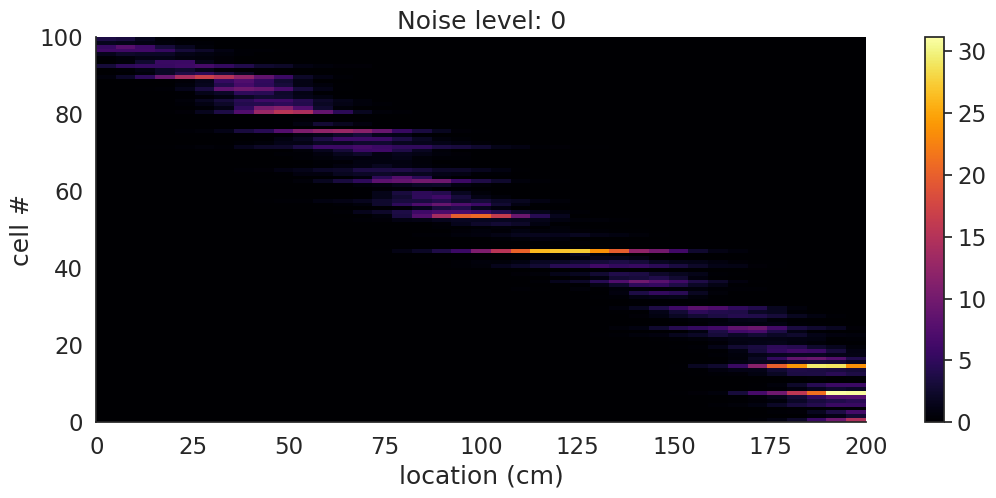

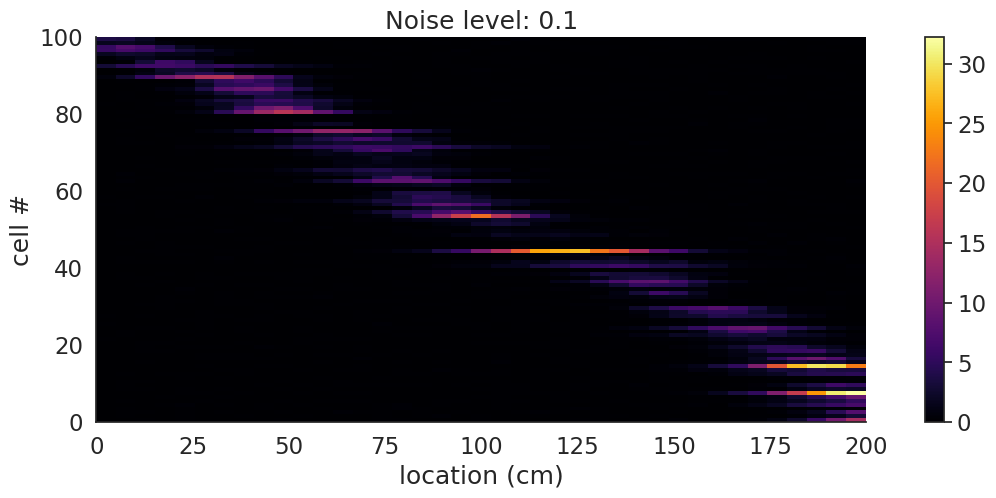

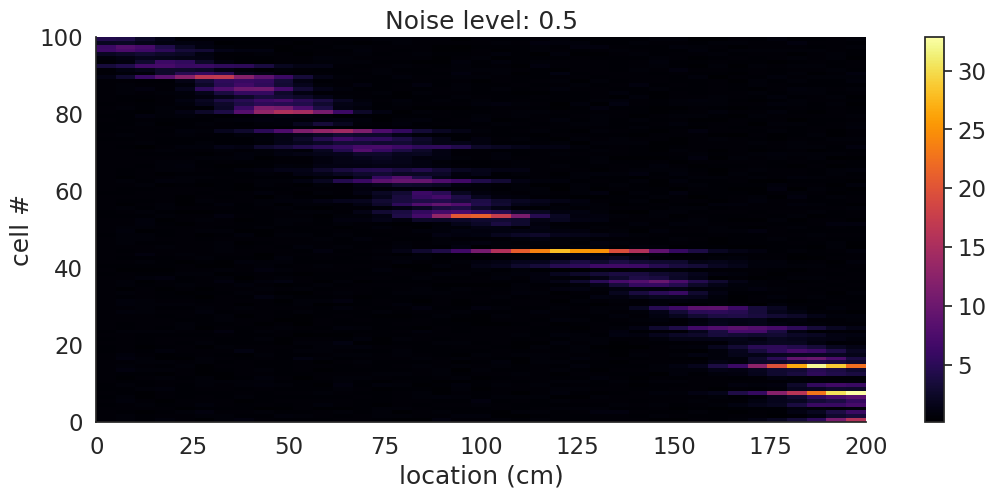

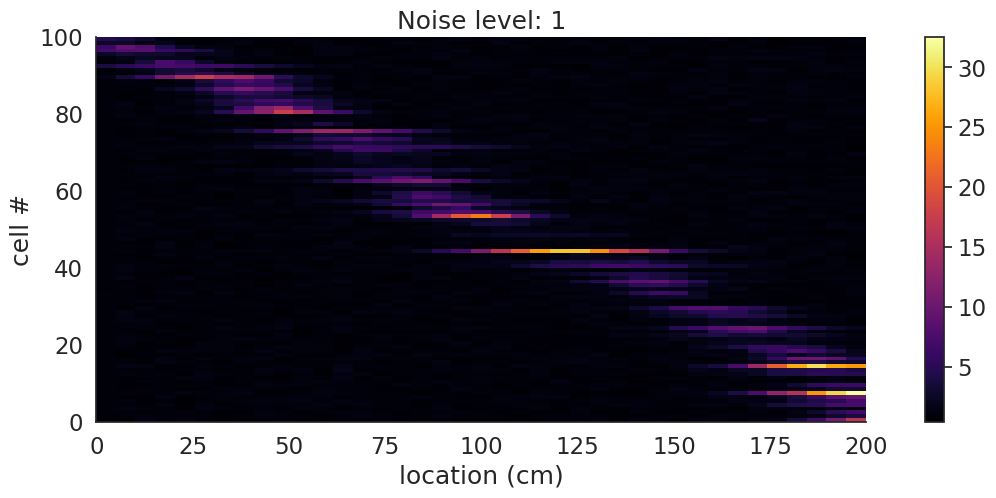

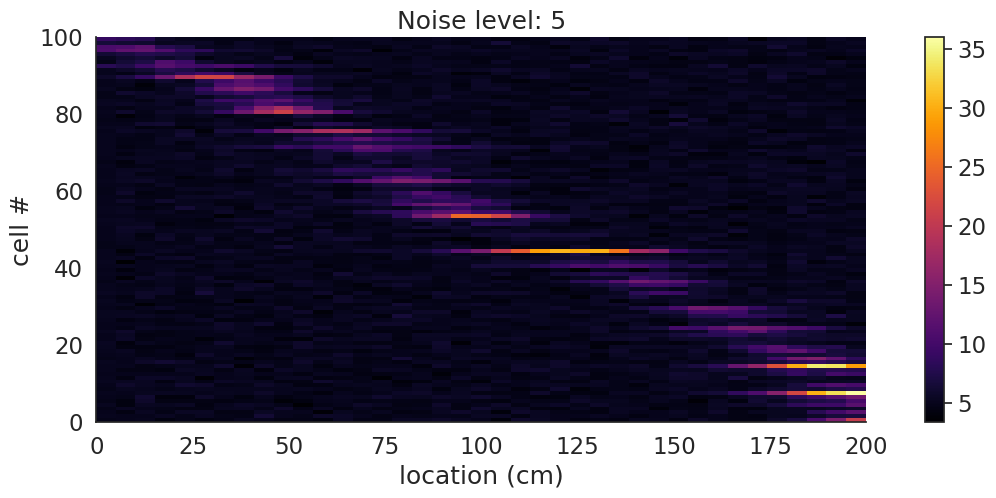

In [73]:
noise_levels = [0, 0.1, 0.5, 1, 5]

for noise_firing_rate in noise_levels:
  testing_noise_levels(noise_firing_rate)

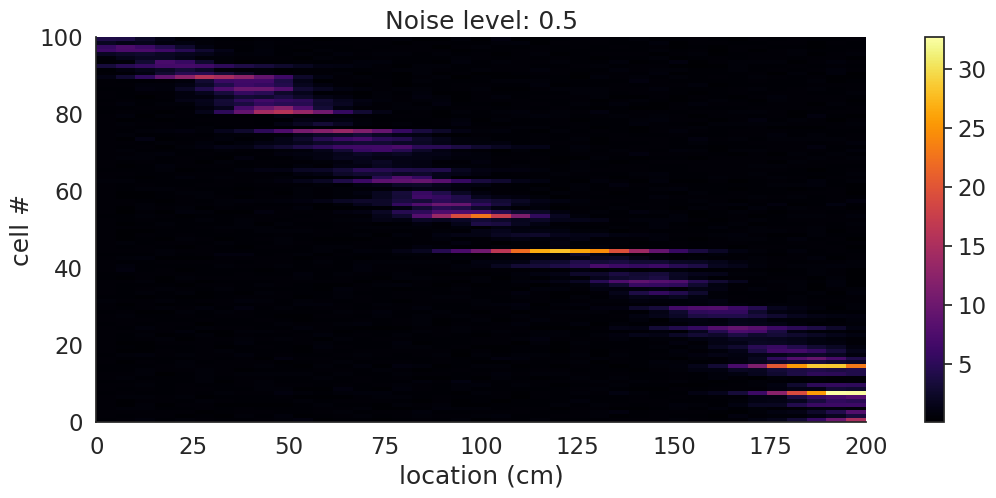

In [24]:
# # plot it

# space_bins = np.arange(0., 200., 5)

# # we compute histograms for each cell
# spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# # put them together into a matrix of floating point numbers (for plotting)
# spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# # we also need an "occupancy histogram" in order to normalize the firing rates maps
# occupancy = np.histogram(x, space_bins)[0] /  fps

# firing_rate_maps = spikes_hist / occupancy

# ix = np.argsort(pf_centers)

# plt.figure(figsize=(15,5))
# plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
# plt.xlabel('location (cm)')
# plt.ylabel('cell #')
# plt.title('Noise level: {}'.format(noise_firing_rate))
# plt.colorbar()

In [9]:
# #again with very high noise

# noise_firing_rate = 1.

# spikes = []

# for i in tqdm(range(n_cells)):
#     inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
#     spikes_loc = np.random.poisson(inst_rate/sampling_rate)
#     sp = np.argwhere(spikes_loc)
#     t_sp = t_sampling[sp]
#     spikes.append(t_sp)

# spike_positions = [np.interp(s, t, x) for s in spikes]

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


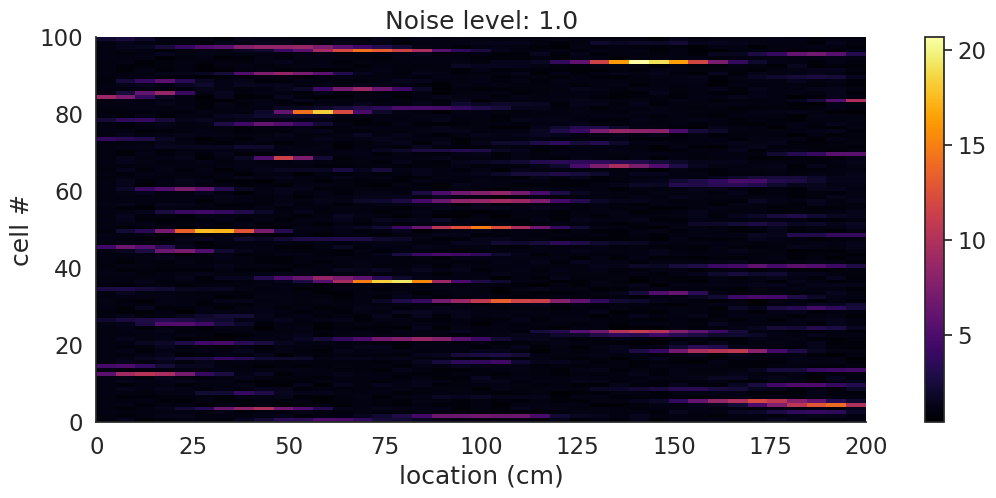

In [10]:
# # plot it

# space_bins = np.arange(0., 200., 5)

# # we compute histograms for each cell
# spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# # put them together into a matrix of floating point numbers (for plotting)
# spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# # we also need an "occupancy histogram" in order to normalize the firing rates maps
# occupancy = np.histogram(x, space_bins)[0] /  fps

# firing_rate_maps = spikes_hist / occupancy

# plt.figure(figsize=(15,5))
# plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
# plt.xlabel('location (cm)')
# plt.ylabel('cell #')
# plt.title('Noise level: {}'.format(noise_firing_rate))
# plt.colorbar()

It seems the graph is more dilluted for higher noise levels. When the noise is high, larger binsizes would be better, so small noise influences get pushed more to the background.

In [3]:
# C

# C - We could use other approaches to firing rate maps: for example make the
# binning very small (down to 1 cm, which is the resolution of our "video" data,
# and then applying a gaussian smoother. Scipy has a Gaussian smoother at scipy.
# stats.gaussian_kde. Read the documentation for that function and apply it to
# the data to define the smoothed firing rate maps. Again, change the noise
# levels and see how the smoother changes.

from scipy.stats import gaussian_kde

In [4]:
?gaussian_kde
# kernel density estimation using gaussian kernels -> probability density

In [ ]:
# firing_rate_maps.shape

(100, 199)

In [ ]:
# spikes_hist.shape

(100, 199)

In [55]:
def testing_noise_levels_with_kde(noise_firing_rate):

  spikes = []

  for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

  spike_positions = [np.interp(s, t, x) for s in spikes]

  # plot it
  space_bins = np.arange(0., 200., 1) # binsize should be small

  # add kde
  kdes = np.zeros((len(spike_positions), 200))

  for i, spike in enumerate(spike_positions):
    # print(i)
    kde = gaussian_kde(spike.T)
    # print(len(kde(bins)))
    kdes[i] = kde(bins)

  peak_locations = kdes.argmax(axis=1)
  ix = np.argsort(peak_locations)

  # plot it
  plt.figure(figsize=(15,5))
  plt.imshow(kdes[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
  plt.xlabel('location (cm)')
  plt.ylabel('cell #')
  plt.title('Noise level: {}'.format(noise_firing_rate))
  plt.colorbar()

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


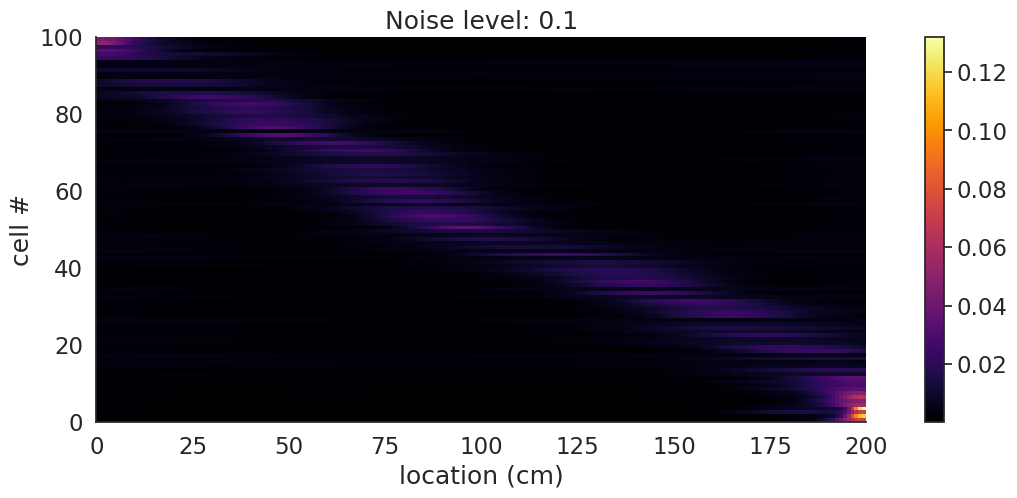

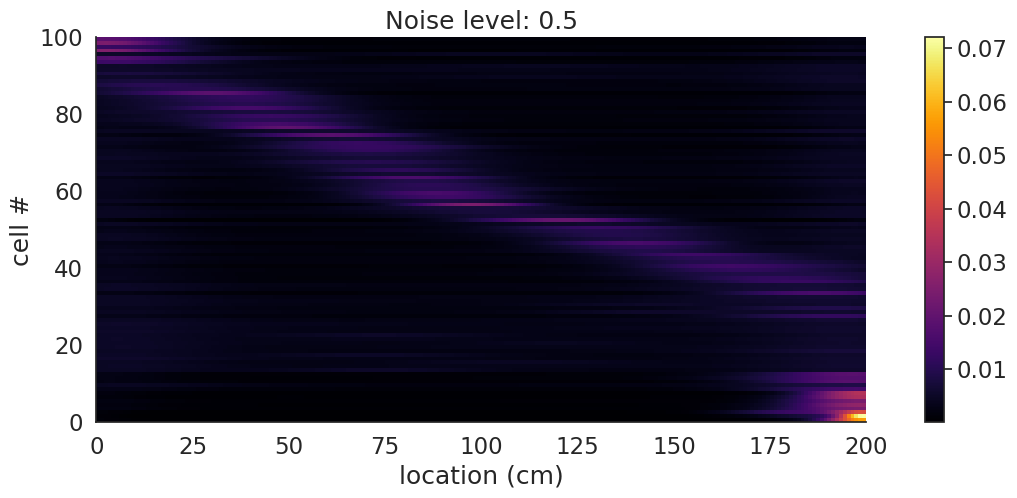

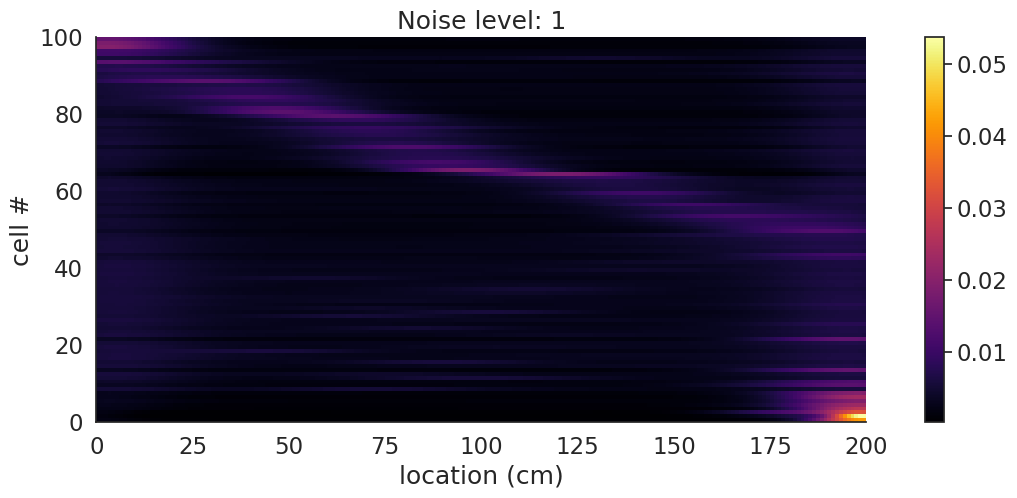

In [56]:
# try it for a few noise levels

noise_levels = [0.1, 0.5, 1]

for noise_firing_rate in noise_levels:
  testing_noise_levels_with_kde(noise_firing_rate)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


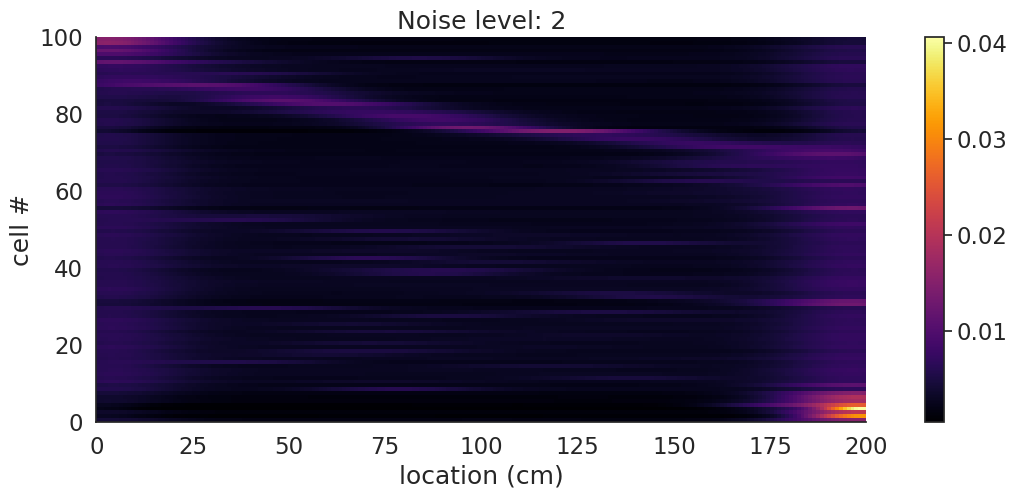

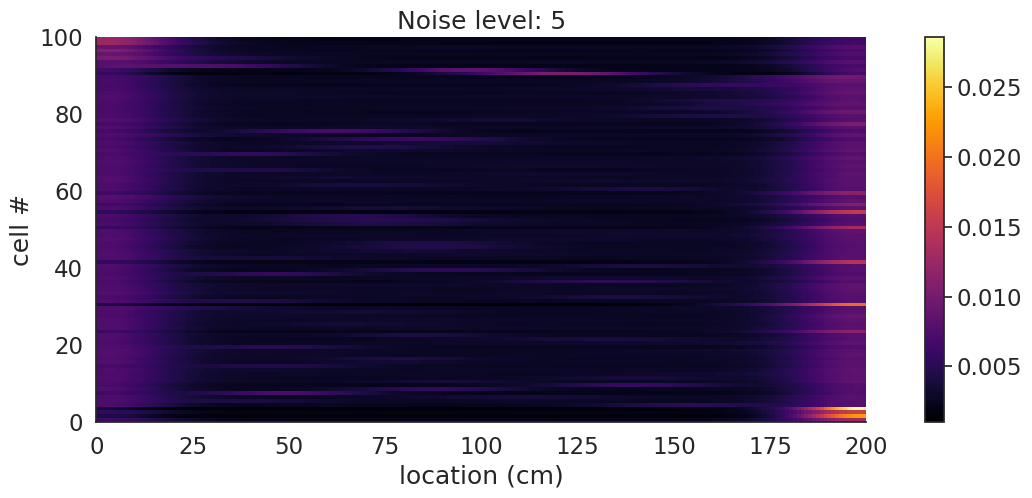

In [38]:
noise_levels = [2, 5]

for noise_firing_rate in noise_levels:
  testing_noise_levels_with_kde(noise_firing_rate)

With kde, it seems noise levels should not get high, as the data becomes illegible then.

**D** place field center and place field width

In [ ]:
# calculate c_pf for each cell

In [53]:
# def calc_cpf(n_spikes, peak_location):
#   return 1/n_spikes

cpfs = np.zeros((n_cells))

for cell in range(n_cells):
  n_spikes = len(spike_positions[cell])
  Li = np.sum(spike_positions[cell])
  c_pf = Li/n_spikes
  cpfs[cell] = c_pf

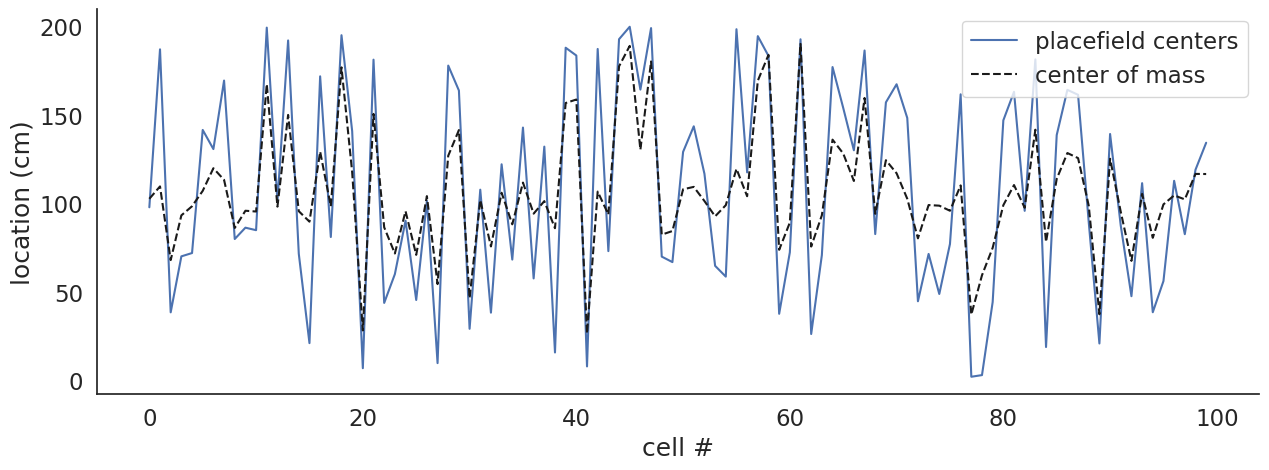

In [54]:
cell_list = np.arange(0, n_cells)

plt.figure(figsize=(15,5))
plt.plot(cell_list, pf_centers, color = 'b', label = 'placefield centers')
plt.plot(cell_list, cpfs, label = 'center of mass', linestyle = 'dashed', color = 'k')
plt.xlabel('cell #')
plt.ylabel('location (cm)')
plt.legend()

plt.show()

It seems to overlap pretty much, so both measures should be fine.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise.
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

In [69]:
# A
eps = 1e-15

# calculate MI between firing of hippocampal cell and position (?)

def mutual_information(cell, eps = 1e-15):

  # for cell in range(n_cells):

    lamb = average_firing_rate
    lx = firing_rate_maps[cell]
    pocc = occupancy

    # calculate I
    I = (lx * np.log2((lx+eps)/lamb*pocc)) # not summed? otherwise no sensible result

    return I

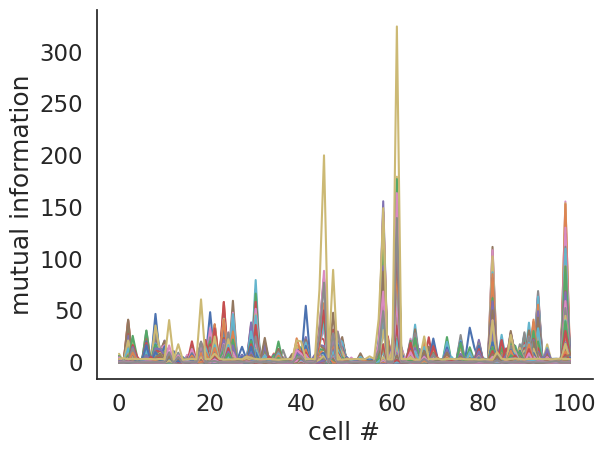

In [70]:
cells = np.arange(0, n_cells)
MI = mutual_information(cells)

plt.plot(cells, MI)
plt.xlabel('cell #')
plt.ylabel('mutual information')
plt.show()

**B**

In [30]:
# adapt the simulation

def adapted_simulation(peak_firing_rate, pf_size, noise_firing_rate):

  n_cells = 5 #speed up

  pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
  pf_size = np.array([pf_size for i in range(n_cells)])#np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
  pf_rate = np.array([peak_firing_rate for i in range(n_cells)])#np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

  true_firing_rate_maps = np.zeros((n_cells, len(bins)))
  for i in range(n_cells):
      true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

  running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
  running_speed_b = np.random.chisquare(10, size=n_runs)

  stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
  stopping_time_b = np.random.chisquare(15, size=n_runs)

  x = np.array([])
  for i in range(n_runs):
      stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
      run_length = len(bins) * fps / running_speed_a[i]
      run1 = np.linspace(0., float(len(bins)-1), int(run_length))
      stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
      run_length = len(bins) * fps / running_speed_b[i]
      run2 = np.linspace(len(bins)-1., 0., int(run_length))
      x = np.concatenate((x, stop1, run1, stop2, run2))
  t = np.arange(len(x))/fps


  t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
  x_sampling = np.floor(np.interp(t_sampling, t, x))

  #noise_firing_rate = 0.5 # the baseline noise firing rate    # noise here!

  spikes = []

  for i in tqdm(range(n_cells)):
      inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
      spikes_loc = np.random.poisson(inst_rate/sampling_rate)
      sp = np.argwhere(spikes_loc)
      t_sp = t_sampling[sp]
      spikes.append(t_sp)

  spike_positions = [np.interp(s, t, x) for s in spikes]


  # plot it
  space_bins = np.arange(0., 200., 5)

  # we compute histograms for each cell
  spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

  # put them together into a matrix of floating point numbers (for plotting)
  spikes_hist = np.vstack(spikes_hist).astype(np.float64)

  # we also need an "occupancy histogram" in order to normalize the firing rates maps
  occupancy = np.histogram(x, space_bins)[0] /  fps

  firing_rate_maps = spikes_hist / occupancy

  eps = 1e-15
  lamb = peak_firing_rate
  lx = firing_rate_maps[0]
  pocc = occupancy
  # calculate I
  I = (lx * np.log2((lx+eps)/lamb*pocc)) # not summed? otherwise no sensible result
  Is = I / lamb

  return I, Is

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


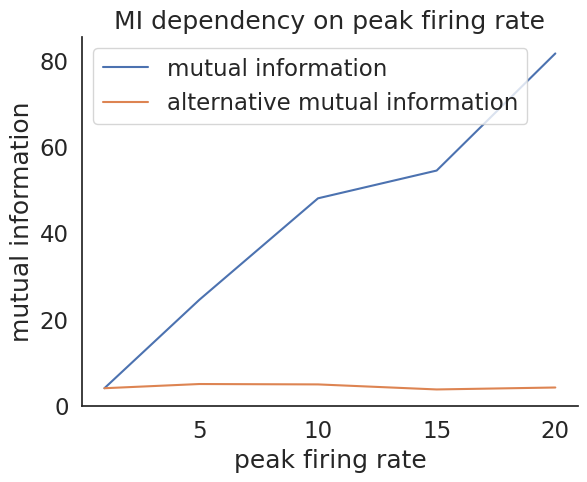

In [29]:
frs = [1, 5, 10, 15, 20]
I = np.zeros((len(frs)))
Is_max = np.zeros((len(frs)))

for i, firing_rate in enumerate(frs):
  I_list, Is_list = adapted_simulation(firing_rate, 5, 0)
  I[i] = np.max(I_list)
  Is_max[i] = np.max(Is_list)

plt.plot(frs, I, label = 'mutual information')
plt.plot(frs, Is_max, label = 'alternative mutual information')
plt.xlabel('peak firing rate')
plt.ylabel('mutual information')
plt.legend()
plt.title('MI dependency on peak firing rate')
plt.show()

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


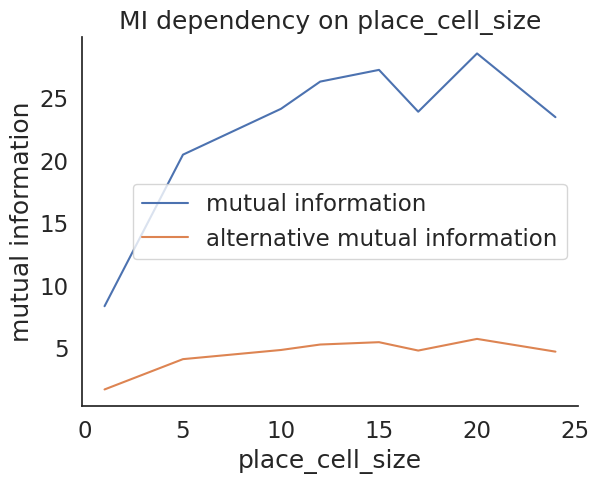

In [35]:
place_cell_sizes = np.sort([1, 5, 10, 12, 24, 17, 15, 20])
I = np.zeros((len(place_cell_sizes)))
Is_max = np.zeros((len(place_cell_sizes)))

for i, place_cell_size in enumerate(place_cell_sizes):
  I_list, Is_list = adapted_simulation(5, place_cell_size, 0)
  I[i] = np.max(I_list)
  Is_max[i] = np.max(Is_list)

plt.plot(place_cell_sizes, I, label = 'mutual information')
plt.plot(place_cell_sizes, Is_max, label = 'alternative mutual information')
plt.xlabel('place_cell_size')
plt.ylabel('mutual information')
plt.legend()
plt.title('MI dependency on place_cell_size')
plt.show()

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


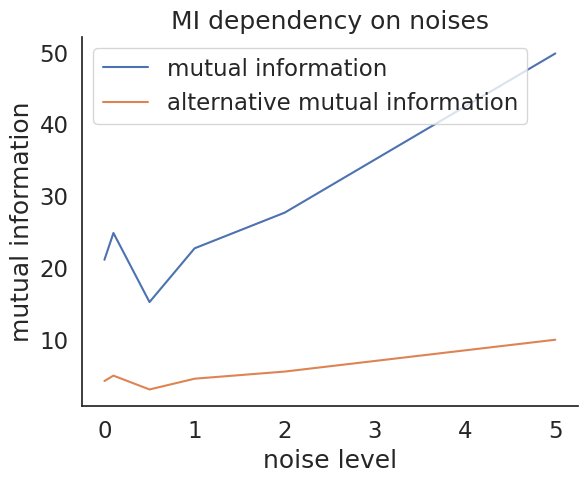

In [34]:
noises = [0, 0.1, 0.5, 1, 2, 5]
I = np.zeros((len(noises)))
Is_max = np.zeros((len(noises)))

for i, noise in enumerate(noises):
  I_list, Is_list = adapted_simulation(5, 5, noise)
  I[i] = np.max(I_list)
  Is_max[i] = np.max(Is_list)

plt.plot(noises, I, label = 'mutual information')
plt.plot(noises, Is_max, label = 'alternative mutual information')
plt.xlabel('noise level')
plt.ylabel('mutual information')
plt.legend()
plt.title('MI dependency on noises')
plt.show()

It seems that in all cases, when the specific parameter increases, firing rate, noise or place cell size, the normal mutual information also increases. This is logical, as there is more information when these parameters increase. The alternative mutual information does not show cleare increase or decrease for these cases.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [38]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
spikes = data['spikes']

<ipython-input-38-50f2fbd08d13>:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(handle)


In [45]:
len(spikes[0])

51024

In [ ]:
n_cells

100

In [ ]:
firing_rate_maps.shape

(100, 199)

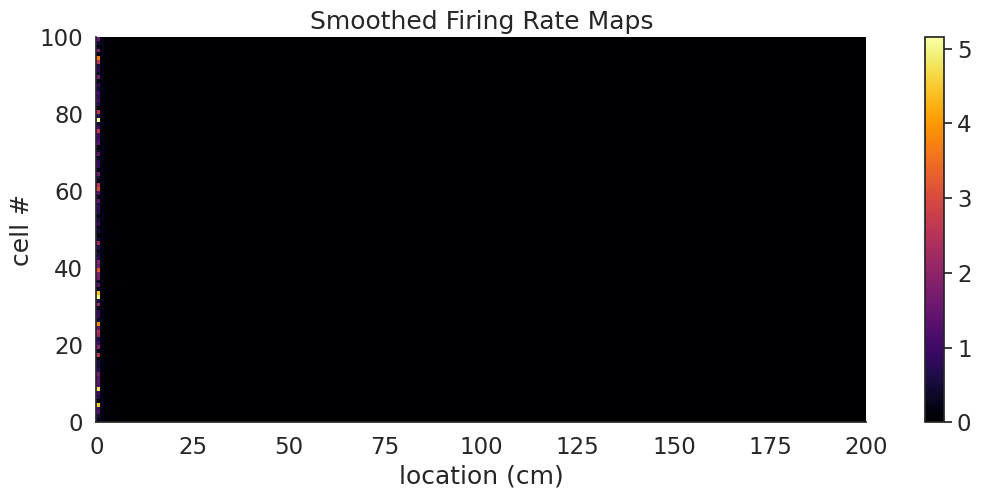

In [ ]:
# smoothed_firing_rate_maps = np.zeros_like(firing_rate_maps)

# for i in range(n_cells):
#     # firing rate map for the current neuron
#     neuron_firing_rate_map = firing_rate_maps[i, :]

#     data_for_kde = neuron_firing_rate_map.reshape(1, -1)
#     kernel = gaussian_kde(data_for_kde)
#     eval_points = space_bins[:-1].reshape(1, -1)
#     smoothed_firing_rate_maps[i, :] = kernel(eval_points)


# # plot it
# plt.figure(figsize=(15,5))
# plt.imshow(smoothed_firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
# plt.xlabel('location (cm)')
# plt.ylabel('cell #')
# plt.title('Smoothed Firing Rate Maps')
# plt.colorbar()